In [7]:
import h5py
import os
import matplotlib.pyplot as plt
import llama.plotting.plotters as p
import llama.api.options as opts
import numpy as np
from importlib import reload
import llama
from llama.dev_utils import reload_module_recursively
import copy

In [2]:
def get_datasets(h5_obj):
    """Returns a list of dataset names in an HDF5 file."""
    dataset_names = []
    
    # with h5py.File(h5_file, 'r') as f:
    def visit_func(name, obj):
        if isinstance(obj, h5py.Dataset):
            dataset_names.append(name)
        
    h5_obj.visititems(visit_func)
    
    return dataset_names

## Look at 2xfm_0704.mda.h5

In [4]:
folder = "/home/beams/HRUTH/Downloads"
file_name = "2xfm_0704.mda.h5"
file_path = os.path.join(folder, file_name)
with h5py.File(file_path) as F:
    # group_name = "/"
    dataset_list = get_datasets(F)
for dataset_name in dataset_list:
    print(os.path.join(dataset_name))


MAPS/Quantification/Calibration/Fitted/Calibration_Curve_DS_IC
MAPS/Quantification/Calibration/Fitted/Calibration_Curve_Labels
MAPS/Quantification/Calibration/Fitted/Calibration_Curve_SR_Current
MAPS/Quantification/Calibration/Fitted/Calibration_Curve_US_IC
MAPS/Quantification/Calibration/NNLS/Calibration_Curve_DS_IC
MAPS/Quantification/Calibration/NNLS/Calibration_Curve_Labels
MAPS/Quantification/Calibration/NNLS/Calibration_Curve_SR_Current
MAPS/Quantification/Calibration/NNLS/Calibration_Curve_US_IC
MAPS/Quantification/Calibration/ROI/Calibration_Curve_DS_IC
MAPS/Quantification/Calibration/ROI/Calibration_Curve_Labels
MAPS/Quantification/Calibration/ROI/Calibration_Curve_SR_Current
MAPS/Quantification/Calibration/ROI/Calibration_Curve_US_IC
MAPS/Quantification/Number_Of_Standards
MAPS/Quantification/Standard0/Element_Weights
MAPS/Quantification/Standard0/Integrated_Spectra/Elapsed_Livetime
MAPS/Quantification/Standard0/Integrated_Spectra/Elapsed_Realtime
MAPS/Quantification/Standard

In [5]:
idx = ["theta" in name for name in dataset_list]
print(np.any(idx))
dataset_list[np.where(idx)[0][0]]

True


'MAPS/Scan/theta'

In [6]:
paths = ['/MAPS/XRF_Analyzed/NNLS/Counts_Per_Sec', '/MAPS/XRF_Analyzed/Fitted/Counts_Per_Sec', '/MAPS/XRF_fits'] # 
# If /MAPS/XRF_fits exists, use that!

In [7]:
# Use V9 structure
with h5py.File(file_path) as F:
    counts_per_second = F["/MAPS/XRF_fits"][()]
    channel_names = F["/MAPS/channel_names"][()]
    theta = F["MAPS/Scan/theta"][()]
    channel_names = [name.decode() for name in channel_names]

In [8]:
%matplotlib widget
from llama.dev_utils import reload_module_recursively
import llama
reload_module_recursively(llama)
import llama.api.options as opts
images = []
for path in paths:
    images += [
        p.ImagePlotObject(
            F[path][()],
            options=opts.ImageSliderPlotOptions(slider=opts.SliderPlotOptions(indexed_titles=channel_names)),
        )
    ]
p.make_image_slider_plot(images, subplot_dims = (3, 1))

KeyError: 'Unable to synchronously open object (invalid identifier type to function)'

## Load nanoCT.h5

In [ ]:
folder = "/net/micdata/data3/hruth/xrf_data/"
file_name = "nanoCT.h5"
file_path = os.path.join(folder, file_name)
F = h5py.File(file_path)


In [ ]:
get_datasets(F)

['defaults/ColorMode',
 'defaults/NDArrayEpicsTSSec',
 'defaults/NDArrayEpicsTSnSec',
 'defaults/NDArrayTimeStamp',
 'defaults/NDArrayUniqueId',
 'defaults/SaveDest',
 'defaults/timestamp',
 'exchange/data',
 'exchange/data_dark',
 'exchange/data_white',
 'exchange/theta',
 'measurement/instrument/attenuator/name',
 'measurement/instrument/attenuator/setup/filter_x',
 'measurement/instrument/attenuator/setup/filter_x_dial',
 'measurement/instrument/beam_monitor/name',
 'measurement/instrument/beam_monitor/setup/beam_monitor_x',
 'measurement/instrument/beam_monitor/setup/beam_monitor_x_dial',
 'measurement/instrument/beam_monitor/setup/beam_monitor_y',
 'measurement/instrument/beam_monitor/setup/beam_monitor_y_dial',
 'measurement/instrument/beam_stop/name',
 'measurement/instrument/beam_stop/setup/beam_stop_x',
 'measurement/instrument/beam_stop/setup/beam_stop_x_dial',
 'measurement/instrument/beam_stop/setup/beam_stop_y',
 'measurement/instrument/beam_stop/setup/beam_stop_y_dial',
 

## Battery particle/Tomo-1-new/

The tomo measurement angle is found here: 

`MAPS/Scan/Extra_PVs/Values` 

in the entry corresponding to the entry of:

`Maps/Scan/Extra_PVs/Names` 

called:

 `"2xfm:m58.VAL"`

In [3]:
import re
from tqdm import tqdm

# Use V9 structure
def get_single_file_data(folder: str, file_name: str) -> dict:
    file_path = os.path.join(folder, file_name)
    with h5py.File(file_path) as F:
        counts_per_second = F["/MAPS/XRF_fits"][()]
        channel_names = F["/MAPS/channel_names"][()]
        channel_names = [name.decode() for name in channel_names]
        counts_dict = {
            channel: counts for channel, counts in zip(channel_names, counts_per_second)
        }
        # Get angle

        PVs = {
            k.decode(): v.decode()
            for k, v in zip(F["MAPS/Scan/Extra_PVs/"]["Names"][()], F["MAPS/Scan/Extra_PVs/"]["Values"][()])
        }
        angle = float(PVs["2xfm:m58.VAL"])
    return counts_dict, angle


def load_all_counts(folder: str, file_names: str) -> dict:
    all_counts_dict = {}
    angles = []
    for name in tqdm(file_names):
        scan_number = int(re.search(r"2xfm_(\d+)\.mda.h5", name).group(1))
        counts_dict, angle = get_single_file_data(folder, name)
        all_counts_dict[scan_number] = counts_dict
        angles += [angle]
    return all_counts_dict, angles


In [4]:
folder = "/net/micdata/data3/hruth/xrf_data/Tomo-1-new/"
tomo_files = os.listdir(folder)
all_counts_dict, angles = load_all_counts(folder, tomo_files)

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:05<00:00, 41.99it/s]


In [ ]:
# [v["Al"] for v in all_counts_dict.values()]
plot_channels = ["Al", "Cl", "Total_Fluorescence_Yield"]

interactive(children=(IntSlider(value=0, description='index', max=249), Output()), _dom_classes=('widget-inter…

Play(value=0, description='Play', interval=500, max=249)

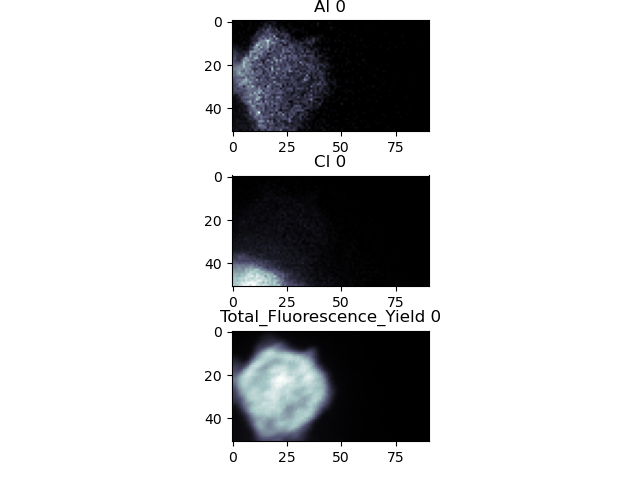

In [5]:
%matplotlib widget
from llama.dev_utils import reload_module_recursively
import llama
reload_module_recursively(llama)
import llama.api.options as opts

plot_channels = ["Al", "Cl", "Total_Fluorescence_Yield"]
images = []
for channel in plot_channels:
    array = [v[channel] for v in all_counts_dict.values()]
    images += [
        p.ImagePlotObject(
            array,
            options=opts.ImageSliderPlotOptions(slider=opts.SliderPlotOptions(title=channel)),
        )
    ]
    del array
p.make_image_slider_plot(images, subplot_dims = (3, 1))

In [ ]:
# from typing import Optional, Sequence, Union
# from llama.alignment.cross_correlation import calculate_alignment_shift
# from llama.api.options.alignment import CrossCorrelationOptions
# from llama.api.options.device import DeviceOptions
# from llama.api.options.plotting import ImageSliderPlotOptions, SliderPlotOptions
# from llama.gpu_utils import pin_memory
# from llama.transformations.helpers import round_to_divisor
# from llama.api.constants import divisor
# from llama.transformations.classes import Shifter
# import copy


# class XRFObject:
#     def __init__(
#         self,
#         counts_per_second: dict[int, dict[str, np.ndarray]],
#         angles: np.ndarray,
#     ):
#         self.counts_per_second = counts_per_second  # key: scan number, value: dict with channel key
#         self.angles = np.array(angles)
#         self.scan_numbers = np.array(list(self.counts_per_second.keys()), dtype=int)
#         self.channels = np.array(list(counts_per_second[self.scan_numbers[0]].keys()))

#     def create_flourescence_arrays(self):
#         self.remove_inconsistent_sizes()
#         self.xrf_arrays = {}
#         for channel in self.channels:
#             self.xrf_arrays[channel] = np.array(
#                 [array[channel] for array in self.counts_per_second.values()]
#             )

#     def remove_inconsistent_sizes(self, channel: str = "Total_Fluorescence_Yield"):
#         # get all unique shapes
#         shapes = [v[channel].shape for v in self.counts_per_second.values()]
#         # Get the count per each shape
#         n_arrays_per_shape = []
#         for shape in set(shapes):
#             n_arrays_per_shape += [shape == x for x in shapes]
#         idx = np.argmax(n_arrays_per_shape)
#         most_common_shape = shapes[idx]
#         idx_keep = [x == most_common_shape for x in shapes]
#         idx_remove = [not x for x in idx_keep]
#         for scan in self.scan_numbers[idx_remove]:
#             del self.counts_per_second[scan]
#         self.angles = self.angles[idx_keep]
#         self.scan_numbers = self.scan_numbers[idx_keep]

#     def pad_arrays(self, shape_divisor: int):
#         def pad_single_array(array: np.ndarray):
#             new_spatial_shape = round_to_divisor(array.shape[1:], "ceil", shape_divisor)
#             pad_amount = new_spatial_shape - np.array(array.shape[1:])
#             pad_by = np.array(
#                 (
#                     (0, 0),
#                     (np.floor(pad_amount[0] / 2), np.ceil(pad_amount[0] / 2)),
#                     (np.floor(pad_amount[1] / 2), np.ceil(pad_amount[1] / 2)),
#                 )
#             ).astype(int)

#             return np.pad(array, pad_by)

#         for channel, array in self.xrf_arrays.items():
#             self.xrf_arrays[channel] = pad_single_array(array)

#     def pin_arrays(self):
#         for channel in self.channels:
#             self.xrf_arrays[channel] = pin_memory(self.xrf_arrays[channel])

#     def get_cross_correlation_shift(self, options: CrossCorrelationOptions, channel: str):
#         dummy_illum_sum = np.ones_like(self.xrf_arrays[channel])[0]
#         self.shift = calculate_alignment_shift(
#             self.xrf_arrays[channel],
#             self.angles,
#             dummy_illum_sum,
#             options,
#         )

#     def shift_xrf_objects(self, device_options: DeviceOptions):
#         shift_options = opts.ShiftOptions(type="circ", enabled=True, device=device_options)
#         for channel in self.channels:
#             self.xrf_arrays[channel] = Shifter(shift_options).run(
#                 self.xrf_arrays[channel], self.shift
#             )

#     def _get_xrf_plot_object(
#         self, channel: str, plot_options: Optional[ImageSliderPlotOptions] = None
#     ) -> p.ImagePlotObject:
#         if plot_options is None:
#             plot_options = ImageSliderPlotOptions(slider=SliderPlotOptions(title=channel))
#         plot_object = p.ImagePlotObject(self.xrf_arrays[channel], options=plot_options)
#         return plot_object

#     def plot_xrf_channels(
#         self,
#         channels: Union[str, list[str]],
#         plot_options: Optional[ImageSliderPlotOptions] = None,
#         subplot_dims: Optional[Sequence] = None,
#     ):
#         if isinstance(channels, str):
#             channels = [channels]
#         plot_objects = []
#         for channel in channels:
#             plot_objects += [self._get_xrf_plot_object(channel, plot_options)]
#         p.make_image_slider_plot(plot_objects, subplot_dims=subplot_dims)

#     def plot_cross_correlation_results(self, device_options: DeviceOptions, channels: list[str]):
#         shift_options = opts.ShiftOptions(type="circ", enabled=True, device=device_options)

#         # Make the plotting objects
#         plot_objects = []
#         # n_cols = 2
#         for row, channel in enumerate(channels):
#             plot_object = self._get_xrf_plot_object(channel)
#             plot_objects += [plot_object]

#             aligned_plot_object = copy.deepcopy(plot_object)
#             aligned_plot_object.array = Shifter(shift_options).run(
#                 self.xrf_arrays[channel], self.shift
#             )
#             aligned_plot_object.options.slider.title = "Aligned"
#             plot_objects += [aligned_plot_object]

#         n_rows = len(channels)
#         n_cols = 2
#         p.make_image_slider_plot(plot_objects, (n_rows, n_cols))
#         plt.show()


In [9]:
from llama.data_structures.xrf_projections import XRFObject
default_device_options = opts.DeviceOptions(
    device_type="gpu",
    gpu=opts.GPUOptions(
        chunking_enabled=True,
        chunk_length=10,
    ),
)
cross_corr_options = opts.CrossCorrelationOptions(
    binning=1,
    filter_position=5,
    iterations=10,
    subtract_smoothed_shift=False,
    device=default_device_options,
)

xrf_object = XRFObject(copy.deepcopy(all_counts_dict), angles)
xrf_object.create_flourescence_arrays()
xrf_object.pad_arrays(4)

xrf_object.get_cross_correlation_shift(cross_corr_options, channel="Total_Fluorescence_Yield")

%matplotlib widget
# plot_channels = ["Total_Fluorescence_Yield", "Al"]
plot_channels = ["Total_Fluorescence_Yield"]
# xrf_object.plot_cross_correlation_results(default_device_options, plot_channels)
xrf_object.shift_xrf_objects(default_device_options)
xrf_object.plot_xrf_channels(plot_channels, subplot_dims=(len(plot_channels), 1))


100%|██████████| 10/10 [00:00<00:00, 11.62it/s]


interactive(children=(IntSlider(value=0, description='index', max=98), Output()), _dom_classes=('widget-intera…

Play(value=0, description='Play', interval=500, max=98)

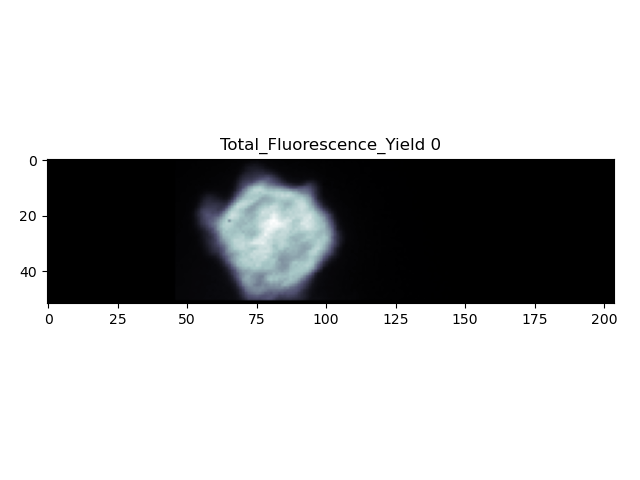

In [10]:
%matplotlib widget
# plot_channels = ["Total_Fluorescence_Yield", "Al"]
plot_channels = ["Total_Fluorescence_Yield"]
# xrf_object.plot_cross_correlation_results(default_device_options, plot_channels)
xrf_object.shift_xrf_objects(default_device_options)
xrf_object.plot_xrf_channels(plot_channels, subplot_dims=(len(plot_channels), 1))